# data

In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
import calendar

# =========================
# Settings (2021-01-01 to 2022-06-30)
# =========================
START = "2021-01-01"
END   = "2025-06-30"

# Month starts: 2021-01-01 ... 2022-06-01
date_range = pd.date_range(start=START, end=END, freq="MS")

# Store GPT views
gpt_means, gpt_vars = [], []
dates = []            # month label (YYYY-MM-01)
sp500_tickers = None  # ticker universe (fixed from first month)

def _month_end(dt: pd.Timestamp) -> str:
    last_day = calendar.monthrange(dt.year, dt.month)[1]
    return dt.replace(day=last_day).strftime("%Y-%m-%d")

for current_date in date_range:
    start_date = current_date.strftime("%Y-%m-%d")
    end_date = _month_end(current_date)

    fp = Path(f"responses/gpt_{start_date}_{end_date}.json")
    if not fp.exists():
        raise FileNotFoundError(f"Missing GPT responses file: {fp}")

    gpt_dict = json.load(open(fp, "r"))

    # Fix ticker universe on first month (stable ordering)
    if sp500_tickers is None:
        sp500_tickers = list(gpt_dict.keys())

    means_row, vars_row = [], []
    for t in sp500_tickers:
        vals = (gpt_dict.get(t, {}) or {}).get("expected_return", None)
        if isinstance(vals, list) and len(vals) > 0:
            means_row.append(float(np.mean(vals)))
            vars_row.append(float(np.var(vals)))
        else:
            means_row.append(np.nan)
            vars_row.append(np.nan)

    gpt_means.append(means_row)
    gpt_vars.append(vars_row)
    dates.append(start_date)


In [2]:
# Views (means/vars) as DataFrames: rows=tickers, columns=month-start dates
gpt_means_df = pd.DataFrame(np.array(gpt_means), index=dates, columns=sp500_tickers).T
gpt_vars_df  = pd.DataFrame(np.array(gpt_vars),  index=dates, columns=sp500_tickers).T

In [3]:
import os
import glob
import pandas as pd

PORT_DIR = "responses_portfolios"

def _find_date_col(df: pd.DataFrame) -> str:
    for c in ["date_key", "Date", "date", "ym"]:
        if c in df.columns:
            return c
    # fallback: first unnamed index column
    if len(df.columns) > 0 and str(df.columns[0]).lower().startswith("unnamed"):
        df = df.rename(columns={df.columns[0]: "date_key"})
        return "date_key"
    raise ValueError(f"Aucune colonne de date trouvée. Colonnes: {list(df.columns)}")

def _read_and_standardize(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    date_col = _find_date_col(df)

    # Standardize to 'date_key' as datetime
    if date_col == "ym":
        # 'YYYY-MM' -> month start
        df["date_key"] = pd.to_datetime(df["ym"].astype(str) + "-01", errors="coerce")
    else:
        df["date_key"] = pd.to_datetime(df[date_col], errors="coerce")

    # drop original date cols (except date_key)
    drop_cols = [c for c in ["Date", "date", "ym"] if c in df.columns and c != "date_key"]
    df = df.drop(columns=drop_cols, errors="ignore")

    # keep only rows with date
    df = df.dropna(subset=["date_key"]).copy()
    return df

def combine_monthly_portfolios(
    pattern: str,
    out_path: str,
) -> pd.DataFrame:
    files = sorted(glob.glob(os.path.join(PORT_DIR, pattern)))
    if not files:
        raise FileNotFoundError(f"Aucun fichier trouvé avec le pattern: {PORT_DIR}/{pattern}")

    dfs = []
    for f in files:
        df = _read_and_standardize(f)
        df["source_file"] = os.path.basename(f)  # pratique pour debug
        dfs.append(df)

    out = pd.concat(dfs, ignore_index=True)

    # sort & drop duplicates by date (keep last)
    out = out.sort_values("date_key")
    out = out.drop_duplicates(subset=["date_key"], keep="last").reset_index(drop=True)

    # save combined
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    out.to_csv(out_path, index=False)
    return out

# ---- Build combined baseline files ----
eq_combined = combine_monthly_portfolios(
    pattern="equal_weighted_portfolio*.csv",
    out_path=os.path.join(PORT_DIR, "equal_weighted_portfolio.csv"),
)

opt_combined = combine_monthly_portfolios(
    pattern="optimized_portfolio*.csv",
    out_path=os.path.join(PORT_DIR, "optimized_portfolio.csv"),
)

print("Baselines combinés :")
print(" -", os.path.join(PORT_DIR, "equal_weighted_portfolio.csv"), "(", len(eq_combined), "rows )")
print(" -", os.path.join(PORT_DIR, "optimized_portfolio.csv"), "(", len(opt_combined), "rows )")
display(eq_combined.head())
display(opt_combined.head())


Baselines combinés :
 - responses_portfolios\equal_weighted_portfolio.csv ( 53 rows )
 - responses_portfolios\optimized_portfolio.csv ( 53 rows )


,Portfolio_Return,date_key,source_file
0,0.061806,2021-02-01,equal_weighted_portfolio_2021-01-01_2021-01-31...
1,0.058421,2021-03-01,equal_weighted_portfolio_2021-02-01_2021-02-28...
2,0.046092,2021-04-01,equal_weighted_portfolio_2021-03-01_2021-03-31...
3,0.018338,2021-05-01,equal_weighted_portfolio_2021-04-01_2021-04-30...
4,0.000543,2021-06-01,equal_weighted_portfolio_2021-05-01_2021-05-31...


,Portfolio_Return,date_key,source_file
0,0.061806,2021-02-01,optimized_portfolio_2021-01-01_2021-01-31.csv
1,0.058421,2021-03-01,optimized_portfolio_2021-02-01_2021-02-28.csv
2,0.046092,2021-04-01,optimized_portfolio_2021-03-01_2021-03-31.csv
3,0.018338,2021-05-01,optimized_portfolio_2021-04-01_2021-04-30.csv
4,0.000543,2021-06-01,optimized_portfolio_2021-05-01_2021-05-31.csv


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

"""
Baselines portfolio returns (generated by baselines.py)
Expected files:
  - responses_portfolios/equal_weighted_portfolio.csv
  - responses_portfolios/optimized_portfolio.csv
"""
equal_weighted_portfolio_returns = pd.read_csv('responses_portfolios/equal_weighted_portfolio.csv')
optimized_portfolio_returns      = pd.read_csv('responses_portfolios/optimized_portfolio.csv')

equal_weighted_portfolio_returns.head()


,Portfolio_Return,date_key,source_file
0,0.061806,2021-02-01,equal_weighted_portfolio_2021-01-01_2021-01-31...
1,0.058421,2021-03-01,equal_weighted_portfolio_2021-02-01_2021-02-28...
2,0.046092,2021-04-01,equal_weighted_portfolio_2021-03-01_2021-03-31...
3,0.018338,2021-05-01,equal_weighted_portfolio_2021-04-01_2021-04-30...
4,0.000543,2021-06-01,equal_weighted_portfolio_2021-05-01_2021-05-31...


In [5]:
"""
GPT monthly portfolio weights (Black-Litterman output from evaluate_multiple_updated.py)
"""
import pandas as pd
import numpy as np

tau = 0.025

weights_path = f"results/gpt_black_litterman_weights_tau_{tau}.csv"
gpt_weights_df = pd.read_csv(weights_path)

# detect date column
if "Date" in gpt_weights_df.columns:
    date_col = "Date"
elif "date_key" in gpt_weights_df.columns:
    date_col = "date_key"
else:
    date_col = gpt_weights_df.columns[0]

gpt_weights_df[date_col] = pd.to_datetime(gpt_weights_df[date_col], errors="coerce")
gpt_weights_df = gpt_weights_df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# transpose for plotting: rows=tickers, columns=dates
gpt_results = gpt_weights_df.T


In [6]:
"""
Gemma3 1B monthly portfolio weights (Black-Litterman output from evaluate_multiple.py)
"""
import pandas as pd
import numpy as np

tau = 0.025

weights_path = f"results/gemma3_black_litterman_weights_tau_{tau}.csv"
gemma_weights_df = pd.read_csv(weights_path)

# detect date column
if "Date" in gemma_weights_df.columns:
    date_col = "Date"
elif "date_key" in gemma_weights_df.columns:
    date_col = "date_key"
else:
    date_col = gemma_weights_df.columns[0]

gemma_weights_df[date_col] = pd.to_datetime(gemma_weights_df[date_col], errors="coerce")
gemma_weights_df = gemma_weights_df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# transpose for plotting: rows=tickers, columns=dates
gemma_results = gemma_weights_df.T


In [7]:
"""
Qwen2.5 1.5B monthly portfolio weights (Black-Litterman output)
"""
import glob
import pandas as pd
import numpy as np

tau = 0.025

# Try a couple of common naming conventions
patterns = [
    f"results/qwen_black_litterman_weights_tau_{tau}.csv",
    f"results/qwen_black_litterman_weights_tau_{tau}_*.csv",
]

candidates = []
for pat in patterns:
    candidates += sorted(glob.glob(pat))

# If both exact + wildcard matched, keep unique
candidates = sorted(set(candidates))
if not candidates:
    raise FileNotFoundError(
        "Could not find Qwen weights CSV in results/. Tried patterns:"
        + "".join(f"- {p}" for p in patterns)
        + "Generate it first (e.g., evaluate_multiple / calculate_llm_returns)."
    )

qwen_weights_path = candidates[-1]
print("Using:", qwen_weights_path)
qwen_weights_df = pd.read_csv(qwen_weights_path)

# detect date column
if "Date" in qwen_weights_df.columns:
    date_col = "Date"
elif "date_key" in qwen_weights_df.columns:
    date_col = "date_key"
else:
    date_col = qwen_weights_df.columns[0]

qwen_weights_df[date_col] = pd.to_datetime(qwen_weights_df[date_col], errors="coerce")
qwen_weights_df = qwen_weights_df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# transpose for plotting: rows=tickers, columns=dates
qwen_results = qwen_weights_df.T
qwen_results.head()


Using: results/qwen_black_litterman_weights_tau_0.025.csv


Date,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,...,2024-09-01,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01
A,1.249222e-18,9.534117e-18,0.000000e+00,1.224108e-17,0.000000e+00,0.000000e+00,6.194169e-18,0.000000e+00,0.000000e+00,1.162147e-17,...,0.000000e+00,0.0,2.435155e-18,4.284552e-18,0.000000e+00,7.777980e-20,1.267634e-17,2.375374e-18,4.148485e-18,4.514216e-18
AAL,1.443814e-18,3.779678e-18,0.000000e+00,0.000000e+00,1.061834e-17,0.000000e+00,8.868624e-18,6.633499e-18,0.000000e+00,2.863461e-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAP,7.974515e-18,0.000000e+00,0.000000e+00,9.998151e-18,0.000000e+00,4.187335e-18,0.000000e+00,0.000000e+00,1.371348e-17,6.841591e-18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAPL,1.334064e-17,1.667018e-17,1.043787e-18,2.349526e-18,3.412667e-17,3.019749e-17,1.298723e-17,1.761919e-17,6.779384e-18,7.863862e-18,...,1.769992e-17,0.0,0.000000e+00,1.601708e-18,0.000000e+00,0.000000e+00,2.660318e-17,1.139625e-17,0.000000e+00,1.882376e-02
ABBV,0.000000e+00,6.256281e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.630565e-17,1.958839e-17,3.331159e-18,0.000000e+00,...,7.752893e-19,0.0,1.355187e-17,0.000000e+00,1.716558e-18,0.000000e+00,1.222630e-17,0.000000e+00,0.000000e+00,0.000000e+00


In [8]:
"""
GPT portfolio returns (generated by calculate_llm_returns.py)
"""
import glob
import pandas as pd

tau = 0.025

# Match: results/gpt_black_litterman_returns_tau_0.025_2021-01-01_2022-06-30.csv
pattern1 = f"results/gpt_black_litterman_returns_tau_{tau}_*.csv"
pattern2 = f"results/gpt_black_litterman_returns_tau_{tau}.csv"

candidates = sorted(glob.glob(pattern1))
if not candidates:
    candidates = sorted(glob.glob(pattern2))

if not candidates:
    raise FileNotFoundError(
        f"Could not find GPT returns CSV in results/. Tried patterns:\n- {pattern1}\n- {pattern2}\n"
        "Run calculate_llm_returns.py first."
    )

gpt_returns_path = candidates[-1]
print("Using:", gpt_returns_path)
gpt_returns = pd.read_csv(gpt_returns_path)
gpt_returns.head()


Using: results\gpt_black_litterman_returns_tau_0.025_2021-01-01_2025-06-30.csv


,date_key,Portfolio_Return
0,2021-02-01,0.041732
1,2021-03-01,-0.024792
2,2021-04-01,-0.007607
3,2021-05-01,0.019609
4,2021-06-01,-0.017169


In [9]:
"""
Gemma3 1B portfolio returns (generated by calculate_llm_returns.py)
"""
import glob
import pandas as pd

tau = 0.025

candidates = sorted(glob.glob(f"results/gemma3_black_litterman_returns_tau_{tau}_*.csv"))
if not candidates:
    candidates = sorted(glob.glob(f"results/gemma3_black_litterman_returns_tau_{tau}.csv"))

if not candidates:
    raise FileNotFoundError("Could not find Gemma3 returns CSV in results/. Run calculate_llm_returns.py first.")

gemma_returns_path = candidates[-1]
print("Using:", gemma_returns_path)
gemma_returns = pd.read_csv(gemma_returns_path)
gemma_returns.head()


Using: results\gemma3_black_litterman_returns_tau_0.025_2021-01-01_2025-06-30.csv


,date_key,Portfolio_Return
0,2021-02-01,0.035764
1,2021-03-01,0.020880
2,2021-04-01,-0.019067
3,2021-05-01,-0.049714
4,2021-06-01,-0.020383


In [10]:
"""
Qwen2.5 1.5B portfolio returns (generated by calculate_llm_returns.py)
"""
import glob
import pandas as pd

tau = 0.025

pattern1 = f"results/qwen_black_litterman_returns_tau_{tau}_*.csv"
pattern2 = f"results/qwen_black_litterman_returns_tau_{tau}.csv"

candidates = sorted(glob.glob(pattern1))
if not candidates:
    candidates = sorted(glob.glob(pattern2))

if not candidates:
    raise FileNotFoundError(
        f"Could not find Qwen returns CSV in results/. Tried patterns:- {pattern1}- {pattern2}"
        "Run calculate_llm_returns.py first."
    )

qwen_returns_path = candidates[-1]
print("Using:", qwen_returns_path)
qwen_returns = pd.read_csv(qwen_returns_path)
qwen_returns.head()


Using: results\qwen_black_litterman_returns_tau_0.025_2021-01-01_2025-06-30.csv


,date_key,Portfolio_Return
0,2021-02-01,0.049248
1,2021-03-01,-0.000837
2,2021-04-01,0.023907
3,2021-05-01,0.037474
4,2021-06-01,0.040982


In [11]:
"""
S&P 500 proxy returns (monthly) from yfinance ETF (e.g., SPY):
- Download daily adjusted prices
- Convert to monthly returns (month-end to month-end)
- Keep Jan..Jun 2025 inclusive
"""
import pandas as pd

try:
    import yfinance as yf
except ImportError:
    raise ImportError("yfinance n'est pas installé. Fais: pip install yfinance")

ETF = "SPY"  # alternatives: "IVV", "VOO"

px = yf.download(ETF, start=START, end=END, progress=False)
if px.empty:
    raise ValueError(f"No data downloaded for {ETF}. Check internet access / ticker.")

# Prefer Adj Close if available, else Close
if "Adj Close" in px.columns:
    close = px["Adj Close"]
else:
    close = px["Close"]

# If DataFrame (edge case), take first column
if isinstance(close, pd.DataFrame):
    close = close.iloc[:, 0]

close = close.dropna()

# Month-end close and monthly returns
m_close = close.resample("ME").last()
m_ret = m_close.pct_change().dropna()

sp500_proxy = pd.DataFrame({
    "date_key": m_ret.index,
    "Portfolio_Return": m_ret.values
})

# Keep months end Jan..Jun 2023
sp500_proxy = sp500_proxy[(sp500_proxy["date_key"] >= START) & (sp500_proxy["date_key"] <= END)].copy()
sp500_proxy


C:\Users\alexi\AppData\Local\Temp\ipykernel_6420\4240315965.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  px = yf.download(ETF, start=START, end=END, progress=False)


,date_key,Portfolio_Return
0,2021-02-28,0.027806
1,2021-03-31,0.045399
2,2021-04-30,0.052911
3,2021-05-31,0.006566
4,2021-06-30,0.022427
5,2021-07-31,0.024412
6,2021-08-31,0.029760
7,2021-09-30,-0.046605
8,2021-10-31,0.070163
9,2021-11-30,-0.008035


# evaluate

In [12]:
import numpy as np
import pandas as pd

def _standardize_returns(df: pd.DataFrame, name: str) -> pd.Series:
    """
    Accepts df with 'Portfolio_Return' and one date column among: date_key / Date / ym.
    Returns a Series indexed by datetime at MONTH START (YYYY-MM-01).
    """
    df = df.copy()

    # Detect date column
    if "date_key" in df.columns:
        dt = pd.to_datetime(df["date_key"], errors="coerce")
    elif "Date" in df.columns:
        dt = pd.to_datetime(df["Date"], errors="coerce")
    elif "ym" in df.columns:
        dt = pd.to_datetime(df["ym"].astype(str) + "-01", errors="coerce")
    else:
        raise ValueError(f"{name}: could not find a date column in {list(df.columns)}")

    if "Portfolio_Return" not in df.columns:
        raise ValueError(f"{name}: missing 'Portfolio_Return' column")

    s = pd.Series(pd.to_numeric(df["Portfolio_Return"], errors="coerce").values, index=dt)
    s = s.dropna()

    # Normalize to month start
    s.index = s.index.to_period("M").to_timestamp()

    # Deduplicate and sort
    s = s[~s.index.duplicated(keep="last")].sort_index()
    return s

def _infer_periods_per_year(index: pd.DatetimeIndex) -> int:
    # For monthly series
    return 12

# Build return series
r_sp500 = _standardize_returns(sp500_proxy, "SP500 proxy")
r_ew    = _standardize_returns(equal_weighted_portfolio_returns, "EW")
r_mvo   = _standardize_returns(optimized_portfolio_returns, "MVO")
r_gpt   = _standardize_returns(gpt_returns, "BLM-GPT")
r_gemma = _standardize_returns(gemma_returns, "BLM-Gemma3_1b")
r_qwen  = _standardize_returns(qwen_returns, "BLM-Qwen2.5_1.5b")

# Align by common dates
common_idx = (r_sp500.index
    .intersection(r_ew.index)
    .intersection(r_mvo.index)
    .intersection(r_gpt.index)
    .intersection(r_gemma.index)
    .intersection(r_qwen.index))

r_sp500 = r_sp500.loc[common_idx]
r_ew    = r_ew.loc[common_idx]
r_mvo   = r_mvo.loc[common_idx]
r_gpt   = r_gpt.loc[common_idx]
r_gemma = r_gemma.loc[common_idx]
r_qwen  = r_qwen.loc[common_idx]

portfolios = {
    "SP500": r_sp500,
    "EW": r_ew,
    "MVO": r_mvo,
    "BLM-GPT": r_gpt,
    "BLM-Gemma3_1b": r_gemma,
    "BLM-Qwen2.5_1.5b": r_qwen,
}

ppy = _infer_periods_per_year(common_idx)
rf = 0.02 / ppy  # per-period risk-free rate (2% annual)

stats = {}
for name, returns in portfolios.items():
    returns = returns.astype(float)
    cum = (1 + returns).prod() - 1
    ann_ret = (1 + cum) ** (ppy / max(1, len(returns))) - 1
    ann_vol = returns.std(ddof=1) * np.sqrt(ppy)
    sharpe = ((returns.mean() - rf) / returns.std(ddof=1)) * np.sqrt(ppy) if returns.std(ddof=1) > 0 else np.nan

    wealth = (1 + returns).cumprod()
    peak = wealth.cummax()
    dd = wealth / peak - 1
    mdd = dd.min()

    stats[name] = {
        "Cum. Return": round(float(cum), 4),
        "Ann. Return": round(float(ann_ret), 4),
        "Ann. Vol": round(float(ann_vol), 4),
        "Sharpe": round(float(sharpe), 4),
        "Max Drawdown": round(float(mdd), 4),
    }

stats_df = pd.DataFrame(stats).T
print(f"Periods/year inferred: {ppy}")
stats_df


Periods/year inferred: 12


,Cum. Return,Ann. Return,Ann. Vol,Sharpe,Max Drawdown
SP500,0.7699,0.1380,0.1598,0.7667,-0.2393
EW,0.6398,0.1185,0.1655,0.6398,-0.1917
MVO,1.2125,0.1970,0.1952,0.9187,-0.1380
BLM-GPT,1.0142,0.1718,0.1846,0.8468,-0.1508
BLM-Gemma3_1b,0.0878,0.0192,0.1883,0.0881,-0.2456
BLM-Qwen2.5_1.5b,0.7173,0.1302,0.1215,0.9076,-0.1622


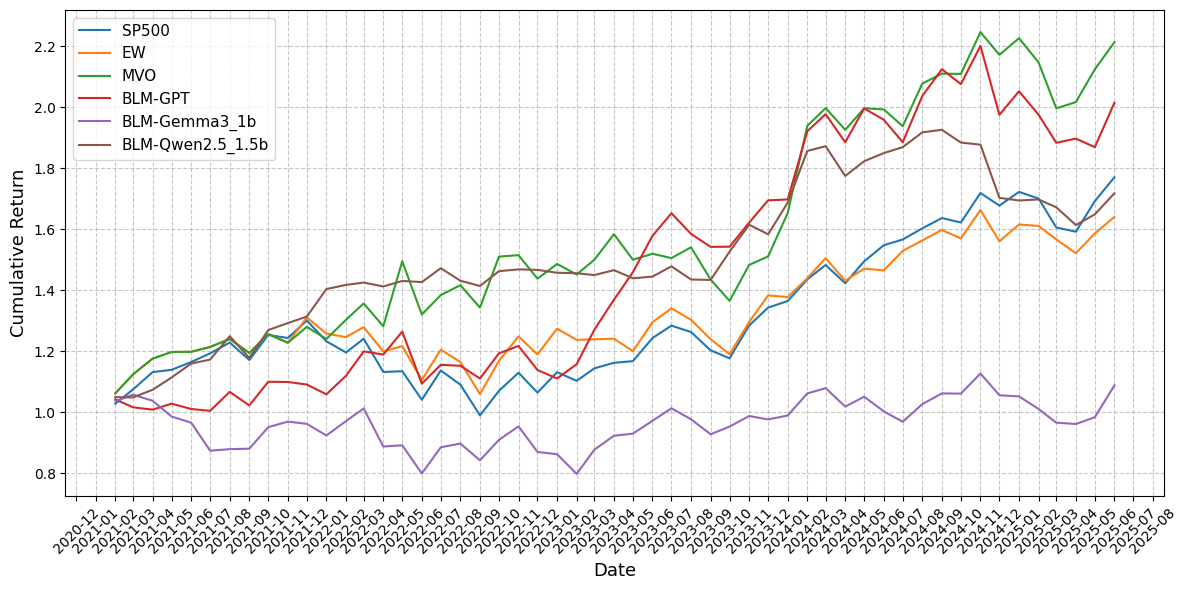

In [13]:
import matplotlib.pyplot as plt
import matplotlib

plt.figure(figsize=(12, 6))

for name, returns in portfolios.items():
    cum = (1 + returns).cumprod()
    plt.plot(cum.index, cum.values, label=name)

plt.grid(True, linestyle="--", alpha=0.7)
plt.xlabel("Date", fontsize=13)
plt.ylabel("Cumulative Return", fontsize=13)
plt.legend(loc="upper left", fontsize=11)

plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [14]:


# Order by value
test = gpt_weights_df.loc[pd.to_datetime('2023-10-01')].sort_values(ascending=False).dropna()
# Drop values with values < 0.01
test = test[test >= 0.01]
test

META    0.283143
ACGL    0.241363
NVDA    0.157544
LLY     0.074351
PGR     0.070729
PG      0.044533
LMT     0.038027
ALL     0.026483
ANET    0.021739
CME     0.017064
HAL     0.016603
Name: 2023-10-01 00:00:00, dtype: float64

In [15]:
test

META    0.283143
ACGL    0.241363
NVDA    0.157544
LLY     0.074351
PGR     0.070729
PG      0.044533
LMT     0.038027
ALL     0.026483
ANET    0.021739
CME     0.017064
HAL     0.016603
Name: 2023-10-01 00:00:00, dtype: float64

In [16]:
gpt_returns

,date_key,Portfolio_Return
0,2021-02-01,0.041732
1,2021-03-01,-0.024792
2,2021-04-01,-0.007607
3,2021-05-01,0.019609
4,2021-06-01,-0.017169
5,2021-07-01,-0.005874
6,2021-08-01,0.061875
7,2021-09-01,-0.041804
8,2021-10-01,0.076032
9,2021-11-01,-0.000673


In [17]:
# Show row where Date = '2023-10-01' from gpt_weights_df
gpt_weights_df.loc[pd.to_datetime('2023-11-01')]

A       0.000000e+00
AAL     9.009477e-18
AAP              NaN
AAPL    1.245403e-17
ABBV    5.826331e-17
            ...     
YUM     8.290236e-18
ZBH     0.000000e+00
ZBRA    1.916323e-18
ZION    5.217064e-18
ZTS     5.141115e-18
Name: 2023-11-01 00:00:00, Length: 476, dtype: float64

In [18]:
dataset = pd.read_csv('yfinance/filtered_sp500_data.csv')
# Keep data from 2023-08 to 2023-12
dataset = dataset[(dataset['date'] >= 20230801) & (dataset['date'] <= 20231231)]
# Keep columns date, tic, stock_ret
dataset = dataset[['date', 'tic', 'stock_ret']]
# Keep rows where 'tic' is STLD and FSLD
dataset = dataset[dataset['tic'].isin(['STLD', 'FSLR'])]

In [19]:
dataset

,date,tic,stock_ret
13030,20230831,STLD,0.000094
13107,20230831,FSLR,-0.088139
13430,20230929,STLD,0.009898
13508,20230929,FSLR,-0.145569
13831,20231031,STLD,-0.006622
13909,20231031,FSLR,-0.118448
14234,20231130,STLD,0.118486
14312,20231130,FSLR,0.107617
14647,20231229,STLD,-0.005078
14728,20231229,FSLR,0.091900
